# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 7e-4

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2023-09-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-09-01 00:00:00', tz='UTC')

In [4]:
groups = [
    'Forex',
    'Cash CFD',
    'Cash II CFD',
    'Metals CFD',
    'Crypto CFD',
    'Exotics',
    'Equities I CFD',
    'Equities II CFD',
    'Agriculture',
    'Commodities'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if (
    ('Agriculture' in symbol.path)
    or ('Cash CFD' in symbol.path)
    or ('Cash II CFD' in symbol.path)
    or ('Crypto CFD' in symbol.path)
    or ('Equities I CFD' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Commodities' in symbol.path)
    # or ('Forex' in symbol.path)
    )
]

print(tickers)

intervals = [
    mt5.TIMEFRAME_H4,
    # mt5.TIMEFRAME_H2,
    # mt5.TIMEFRAME_H1,
    # mt5.TIMEFRAME_M15,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['GER40.cash', 'UK100.cash', 'US100.cash', 'US30.cash', 'US500.cash', 'AUS200.cash', 'EU50.cash', 'FRA40.cash', 'HK50.cash', 'JP225.cash', 'N25.cash', 'SPN35.cash', 'US2000.cash', 'UKOIL.cash', 'USOIL.cash', 'ADAUSD', 'BTCUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'ETHUSD', 'LTCUSD', 'NEOUSD', 'XMRUSD', 'XRPUSD', 'AAPL', 'AMZN', 'BABA', 'BAC', 'GOOG', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'RACE', 'T', 'TSLA', 'V', 'WMT', 'ZM', 'AIRF', 'ALVG', 'BAYGn', 'DBKGn', 'IBE', 'LVMH', 'VOWG_p', 'META', 'COCOA.c', 'COFFEE.c', 'CORN.c', 'SOYBEAN.c', 'WHEAT.c', 'NATGAS.cash']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
GER40.cash
UK100.cash
US100.cash
US30.cash
US500.cash
AUS200.cash
EU50.cash
FRA40.cash
HK50.cash
JP225.cash
N25.cash
SPN35.cash
US2000.cash
UKOIL.cash
USOIL.cash
ADAUSD
BTCUSD
DASHUSD
DOGEUSD
DOTUSD
ETHUSD
LTCUSD
NEOUSD
XMRUSD
XRPUSD
AAPL
AMZN
BABA
BAC
GOOG
MSFT
NFLX
NVDA
PFE
RACE
T
TSLA
V
WMT
ZM
AIRF
ALVG
BAYGn
DBKGn
IBE
LVMH
VOWG_p
META
COCOA.c
COFFEE.c


In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


intervals_start_dates


print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16388: Timestamp('2024-10-23 00:00:00+0000', tz='UTC')}
2023-09-01 00:00:00+00:00
2024-09-01 00:00:00+00:00


# Estrategia

In [7]:
from backbone.day_per_week_strategy import DayPerWeek
    
STRATEGY = DayPerWeek

# Analisis preliminar

In [8]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


AAPL 16388
ADAUSD 16388
AIRF 16388
ALVG 16388
AMZN 16388
AUS200.cash 16388
BABA 16388
BAC 16388
BAYGn 16388
BTCUSD 16388
COCOA.c 16388
COFFEE.c 16388
CORN.c 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


DASHUSD 16388
DBKGn 16388
DOGEUSD 16388
DOTUSD 16388
ETHUSD 16388
EU50.cash 16388
FRA40.cash 16388
GER40.cash 16388
GOOG 16388
HK50.cash 16388
IBE 16388
JP225.cash 16388
LTCUSD 16388
LVMH 16388
META 16388
MSFT 16388
N25.cash 16388
NATGAS.cash 16388
hubo un problema con NATGAS.cash 16388: OHLC `data` is empty
NEOUSD 16388
NFLX 16388
NVDA 16388
PFE 16388
RACE 16388
SOYBEAN.c 16388
SPN35.cash 16388
T 16388
TSLA 16388
UK100.cash 16388
UKOIL.cash 16388
US100.cash 16388
US2000.cash 16388
US30.cash 16388
US500.cash 16388
USOIL.cash 16388
V 16388
VOWG_p 16388
WHEAT.c 16388
WMT 16388
XMRUSD 16388
XRPUSD 16388
ZM 16388


In [11]:

filter_performance = performance[
    (performance['return/dd']>0)
    # & (performance['stability_ratio']>0.7)
].sort_values(by=['return/dd'], ascending=[False])#.drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DayPerWeek,FRA40.cash,16388,0.858877,2.021785,10202.178533,0.545338,154 days 08:00:00,70.212766,2.434076,47,0.212255,23.173140,10202.178533,364 days 20:00:00,3.707397,5.064741
0,DayPerWeek,WMT,16388,0.822441,2.850835,10285.083544,1.090841,57 days 00:00:00,68.181818,1.422477,22,0.627648,39.400000,10285.083544,364 days 04:00:00,2.613430,4.275208
0,DayPerWeek,JP225.cash,16388,0.755087,2.355413,10235.541255,0.941414,99 days 08:00:00,73.913043,1.426620,46,0.256301,29.980532,10235.541255,364 days 20:00:00,2.501995,4.671176
0,DayPerWeek,USOIL.cash,16388,0.807719,3.054530,10305.452968,1.558230,133 days 16:00:00,89.189189,1.480723,37,0.395270,17.312661,10305.452968,364 days 20:00:00,1.960256,4.343282
0,DayPerWeek,ALVG,16388,0.852222,2.107936,10210.793642,1.280847,43 days 00:00:00,76.666667,1.315570,30,0.328293,34.947644,10210.793642,364 days 08:00:00,1.645736,3.173657
0,DayPerWeek,US100.cash,16388,0.824288,1.134310,10113.431038,0.902722,71 days 16:00:00,70.689655,0.712075,58,0.097324,34.046693,10113.431038,364 days 20:00:00,1.256544,2.430829
0,DayPerWeek,US2000.cash,16388,0.700642,1.464534,10146.453410,1.335210,101 days 20:00:00,68.085106,0.643970,47,0.145389,27.255029,10146.453410,364 days 20:00:00,1.096857,2.427836
0,DayPerWeek,EU50.cash,16388,0.465899,1.098509,10109.850853,1.174215,157 days 08:00:00,73.684211,1.001706,57,0.094787,24.313725,10109.850853,364 days 20:00:00,0.935526,2.051514
0,DayPerWeek,NFLX,16388,0.629760,2.039867,10203.986671,2.251111,64 days 00:00:00,66.666667,0.714428,21,0.450468,37.200000,10203.986671,364 days 04:00:00,0.906160,1.939434
0,DayPerWeek,NVDA,16388,0.739473,4.620615,10462.061548,5.700093,78 days 00:00:00,60.000000,0.808548,30,0.642970,31.000000,10462.061548,364 days 04:00:00,0.810621,2.368196


In [14]:
for ticker, interval in zip(portfolio, intervals):
    
    prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]
    
    df_stats = run_strategy(
        strategy=STRATEGY,
        ticker=ticker,
        interval=interval,
        commission=COMMISSION, 
        prices=prices, 
        initial_cash=INITIAL_CASH, 
        margin=MARGIN,
        plot=True
    )
    
    break

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


# WFO

In [12]:
lookback_bars_per_interval = {
    16388: 1200,
    16386: 1800,
}

In [13]:
from backbone.utils.wfo_utils import optimization_function

validation_bars = 180
warmup_bars = 200

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'day_to_buy': list(np.arange(0, 5, 1)),
    'percentage_price_sl': list(np.arange(2, 20, 2)),
}

for ticker, interval, strategy in experiments:
    
    try:
        print(ticker, interval)
        
        lookback_bars = lookback_bars_per_interval[interval]
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

AAPL 16388
ADAUSD 16388
AIRF 16388
ALVG 16388
AMZN 16388
AUS200.cash 16388
BABA 16388
BAC 16388
BAYGn 16388
BTCUSD 16388
COCOA.c 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:158: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_training = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:175: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_validation = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:158: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_training = Backte

COFFEE.c 16388
CORN.c 16388
DASHUSD 16388
DBKGn 16388
DOGEUSD 16388
DOTUSD 16388
ETHUSD 16388
EU50.cash 16388
FRA40.cash 16388
GER40.cash 16388
GOOG 16388
HK50.cash 16388
IBE 16388
JP225.cash 16388
LTCUSD 16388
LVMH 16388
META 16388
MSFT 16388
N25.cash 16388
No se pudo ejecutar para el ticker N25.cash: index -1 is out of bounds for axis 0 with size 0
NATGAS.cash 16388
No se pudo ejecutar para el ticker NATGAS.cash: index -1 is out of bounds for axis 0 with size 0
NEOUSD 16388
NFLX 16388
NVDA 16388
PFE 16388
RACE 16388
SOYBEAN.c 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


SPN35.cash 16388
T 16388
TSLA 16388
UK100.cash 16388
UKOIL.cash 16388
US100.cash 16388
US2000.cash 16388
US30.cash 16388
US500.cash 16388
USOIL.cash 16388
V 16388
VOWG_p 16388
WHEAT.c 16388
WMT 16388
XMRUSD 16388
XRPUSD 16388
ZM 16388


In [15]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filter_performance.iterrows():
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        prices = symbols[ticker][interval]
        params = all_opt_params[ticker][interval]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=True
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


FRA40.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WMT 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


JP225.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


USOIL.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


ALVG 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


US100.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


US2000.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


EU50.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NFLX 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NVDA 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


US500.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GOOG 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DOGEUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


PFE 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


BAC 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


META 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GER40.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


IBE 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


AMZN 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


BABA 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


COCOA.c 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


UKOIL.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


SPN35.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DBKGn 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


AAPL 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NEOUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


In [17]:
filtered_wfo_performance = performance[
    # (performance['stability_ratio'] > 0.6)
    (performance['return/dd'] > 1.9)
].sort_values(by='return/dd', ascending=False)

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DayPerWeek,USOIL.cash,16388,0.592604,12.166305,11216.630539,3.614298,291 days 00:00:00,76.271186,1.019583,118,0.224698,22.601374,11216.630539,1064 days 20:00:00,3.366160,12.600892
0,DayPerWeek,UKOIL.cash,16388,0.787779,9.334707,10933.470675,3.644617,214 days 12:00:00,70.312500,0.695160,128,0.269980,22.512741,10933.470675,1064 days 20:00:00,2.561231,9.767203
0,DayPerWeek,US100.cash,16388,0.720771,4.441321,10444.132074,2.260401,412 days 16:00:00,73.469388,0.449850,147,0.023517,29.047302,10444.132074,1064 days 20:00:00,1.964838,6.807207


# Montecarlo

In [18]:
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][interval]._trades
    eq_curve = stats_per_symbol[ticker][interval]._equity_curve
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
        equity_curve=eq_curve,
        trade_history=trades_history, 
        n_simulations=100_000, 
        initial_equity=INITIAL_CASH, 
        threshold_ruin=0.8, 
        return_raw_curves=True,
        percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
    )
    
    montecarlo_simulations[ticker] = mc
    
    synthetic_drawdown_curve['ticker'] = ticker
    synthetic_return_curve['ticker'] = ticker
    
    all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
    all_returns = pd.concat([all_returns, synthetic_return_curve])

Procesando ticker: USOIL.cash
Procesando ticker: UKOIL.cash
Procesando ticker: US100.cash


In [19]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_USOIL.cash,drawdown_UKOIL.cash,drawdown_US100.cash
count,100000.000000,100000.000000,100000.000000
mean,-1.657061,-2.360431,-0.871226
std,0.798512,1.138622,0.399824
min,-9.184456,-9.698743,-4.121067
10%,-2.727679,-3.936271,-1.406500
25%,-2.048815,-2.987506,-1.065010
50%,-1.485415,-2.123600,-0.783918
75%,-1.082072,-1.509797,-0.583418
90%,-0.820723,-1.118895,-0.455537
max,-0.157409,-0.285399,-0.148338


,return_USOIL.cash,return_UKOIL.cash,return_US100.cash
count,100000.000000,100000.000000,100000.000000
mean,2.690482,0.240941,1.170708
std,2.447890,2.370668,1.158813
min,-9.222888,-9.170228,-3.964022
10%,-0.428647,-2.788616,-0.315113
25%,1.028573,-1.374170,0.388662
50%,2.650127,0.210401,1.167253
75%,4.317759,1.831560,1.947149
90%,5.844450,3.291031,2.655664
max,13.361399,12.415780,6.987790


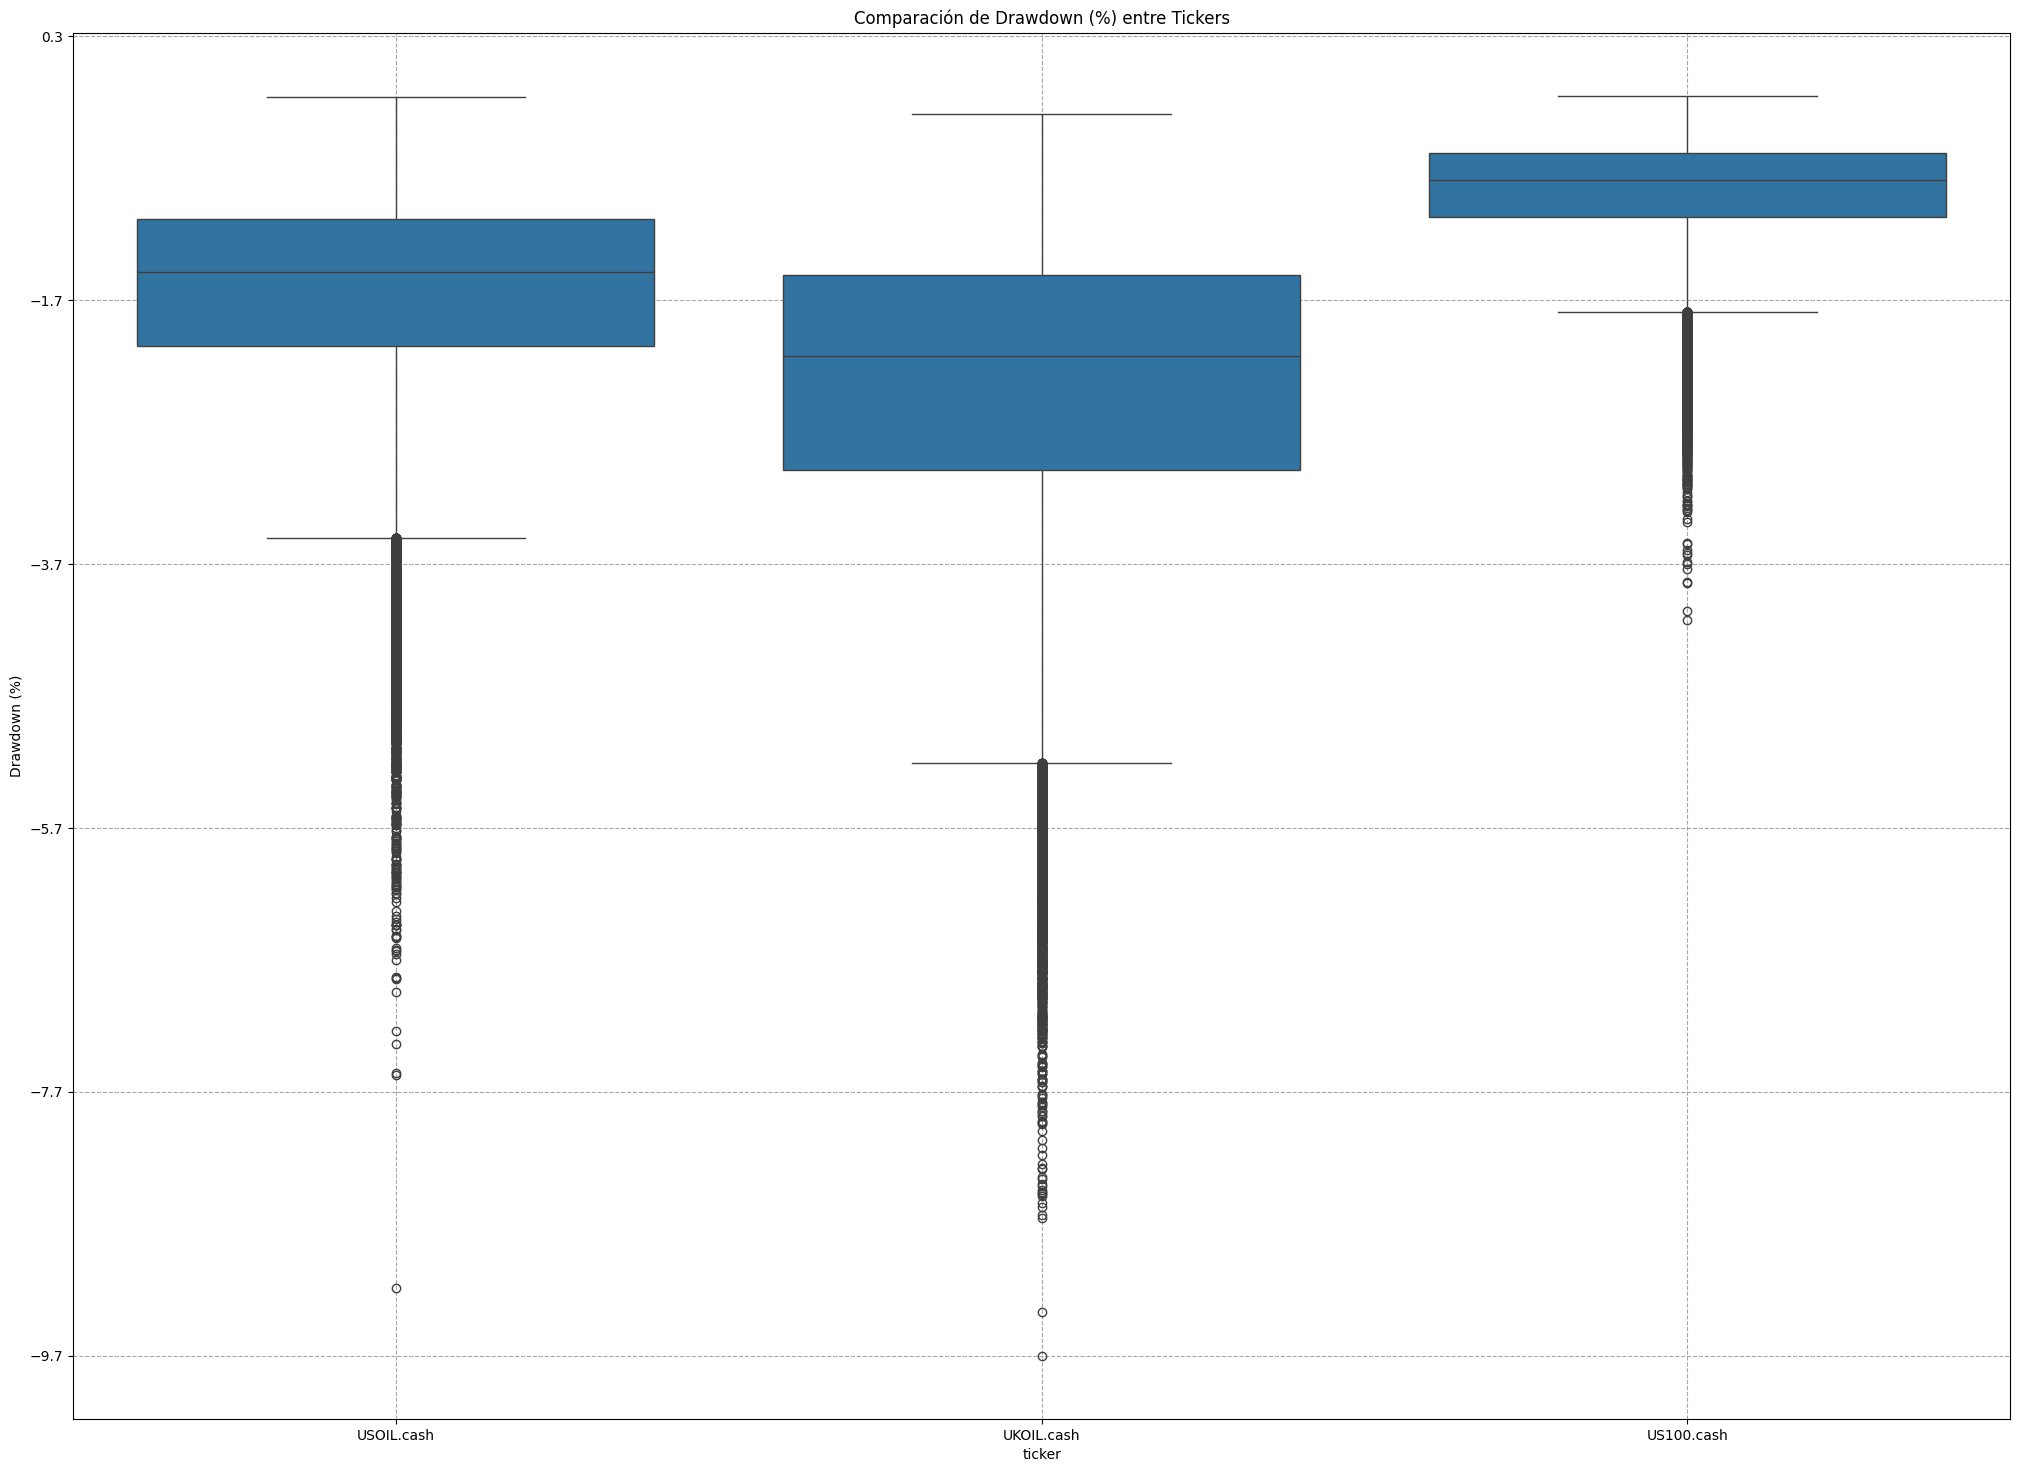

In [20]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


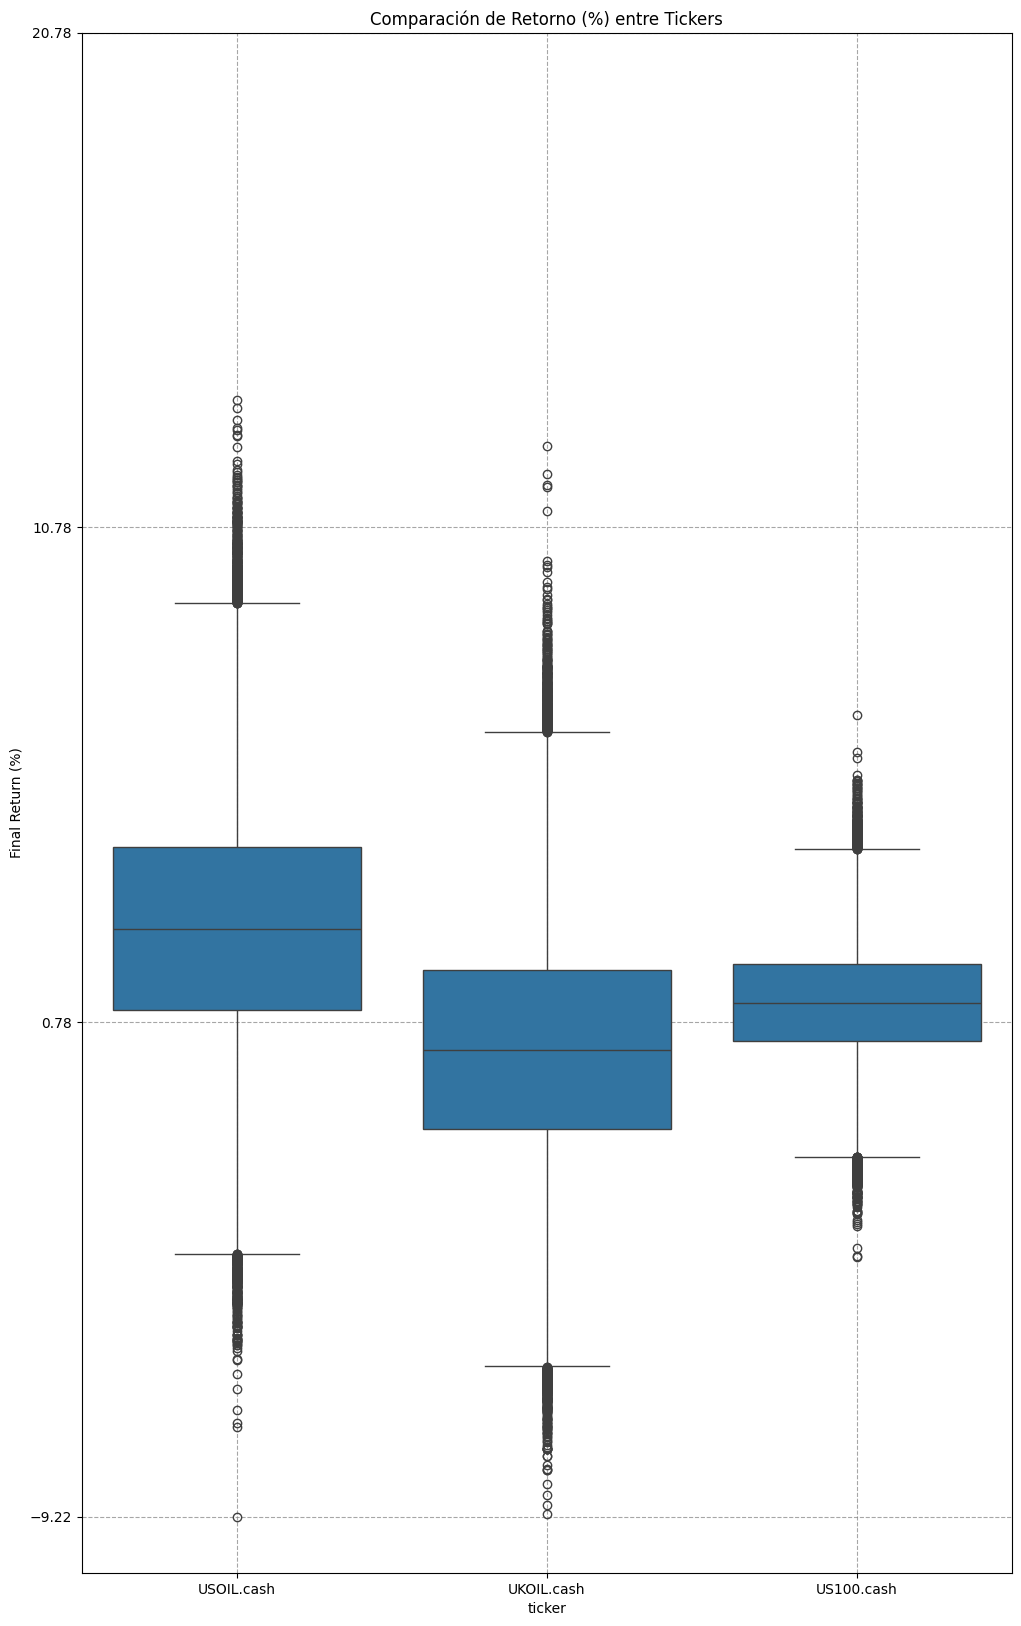

In [21]:
# Generar el gráfico
plt.figure(figsize=(12, 20))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
